In [ ]:
!pip install contractions
!pip install wordcloud
!pip install nltk

In [ ]:
import nltk
nltk.download('all')

In [5]:
import pandas as pd
from googleapiclient.discovery import build
from nltk.tokenize import word_tokenize
import contractions
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag, RegexpParser
from nltk import ne_chunk
import string
from collections import Counter
from wordcloud import WordCloud
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

# **1 Data Collection**

In [ ]:
# Get comments from the specified YouTube video
def get_all_youtube_comments(api_key, video_id):
    youtube = build('youtube', 'v3', developerKey=api_key)

    comments = []
    thread_ids = []
    next_page_token = None

    while True:
        comments_response = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            maxResults=100,
            pageToken=next_page_token
        ).execute()

        for item in comments_response['items']:
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            thread_id = item['id']
            comments.append(comment)
            thread_ids.append(thread_id)

        if 'nextPageToken' in comments_response:
            next_page_token = comments_response['nextPageToken']
        else:
            break

    comments_df = pd.DataFrame({'Thread ID': thread_ids, 'Comment': comments})

    return comments_df

In [ ]:
api_key = '<---enter your api key--->'
video_id = 'Eo-oFWyxdUo'

df_comments = get_all_youtube_comments(api_key, video_id)

output_file = 'youtube_comments.csv'
df_comments.to_csv(output_file, index=False)

# **2 Data Preparation**

In [6]:
df = pd.read_csv('/content/youtube_comments.csv')
df

,Thread ID,Comment
0,UgxkceJ0F6__Z3bjQNZ4AaABAg,"Can someone tell me, why MKBHD stopped reviewi..."
1,UgxDjx9DXh_aYMqfKeJ4AaABAg,i bought fold 3 yesterday because of its way c...
2,Ugw7CyPzykp7gd-6I0B4AaABAg,삼성 폰 많이 사주세요
3,UgwsOiu_uADVKO7jjUZ4AaABAg,It sucks Android can&#39;t handle certain DJ a...
4,UgwoIURLQ4SNKo82Gzt4AaABAg,How much is the z fold 5?
...,...,...
4616,UgymEuVlsbSLojgABeF4AaABAg,First one here
4617,UgyebOKVDyQCNoSp09B4AaABAg,first
4618,UgxtPT248Q5-pHTjAAF4AaABAg,"<a href=""about:invalid#zCSafez""></a>"
4619,UgzB_DG0nAR9FDje40N4AaABAg,First


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4621 entries, 0 to 4620
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Thread ID  4621 non-null   object
 1   Comment    4620 non-null   object
dtypes: object(2)
memory usage: 72.3+ KB


In [8]:
df = df.dropna()
df

,Thread ID,Comment
0,UgxkceJ0F6__Z3bjQNZ4AaABAg,"Can someone tell me, why MKBHD stopped reviewi..."
1,UgxDjx9DXh_aYMqfKeJ4AaABAg,i bought fold 3 yesterday because of its way c...
2,Ugw7CyPzykp7gd-6I0B4AaABAg,삼성 폰 많이 사주세요
3,UgwsOiu_uADVKO7jjUZ4AaABAg,It sucks Android can&#39;t handle certain DJ a...
4,UgwoIURLQ4SNKo82Gzt4AaABAg,How much is the z fold 5?
...,...,...
4616,UgymEuVlsbSLojgABeF4AaABAg,First one here
4617,UgyebOKVDyQCNoSp09B4AaABAg,first
4618,UgxtPT248Q5-pHTjAAF4AaABAg,"<a href=""about:invalid#zCSafez""></a>"
4619,UgzB_DG0nAR9FDje40N4AaABAg,First


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4620 entries, 0 to 4620
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Thread ID  4620 non-null   object
 1   Comment    4620 non-null   object
dtypes: object(2)
memory usage: 108.3+ KB


In [10]:
df = df.copy()
df['comment_length'] = df['Comment'].str.len()
df

,Thread ID,Comment,comment_length
0,UgxkceJ0F6__Z3bjQNZ4AaABAg,"Can someone tell me, why MKBHD stopped reviewi...",65
1,UgxDjx9DXh_aYMqfKeJ4AaABAg,i bought fold 3 yesterday because of its way c...,107
2,Ugw7CyPzykp7gd-6I0B4AaABAg,삼성 폰 많이 사주세요,12
3,UgwsOiu_uADVKO7jjUZ4AaABAg,It sucks Android can&#39;t handle certain DJ a...,184
4,UgwoIURLQ4SNKo82Gzt4AaABAg,How much is the z fold 5?,25
...,...,...,...
4616,UgymEuVlsbSLojgABeF4AaABAg,First one here,14
4617,UgyebOKVDyQCNoSp09B4AaABAg,first,5
4618,UgxtPT248Q5-pHTjAAF4AaABAg,"<a href=""about:invalid#zCSafez""></a>",36
4619,UgzB_DG0nAR9FDje40N4AaABAg,First,5


In [11]:
df.describe()

,comment_length
count,4620.000000
mean,149.776407
std,236.317072
min,1.000000
25%,49.000000
50%,94.000000
75%,178.000000
max,9533.000000


## 2.1 Converting to Lowercase

In [12]:
# Convert the 'Comment' column to lowercase
df['Comment'] = df['Comment'].str.lower()
df

,Thread ID,Comment,comment_length
0,UgxkceJ0F6__Z3bjQNZ4AaABAg,"can someone tell me, why mkbhd stopped reviewi...",65
1,UgxDjx9DXh_aYMqfKeJ4AaABAg,i bought fold 3 yesterday because of its way c...,107
2,Ugw7CyPzykp7gd-6I0B4AaABAg,삼성 폰 많이 사주세요,12
3,UgwsOiu_uADVKO7jjUZ4AaABAg,it sucks android can&#39;t handle certain dj a...,184
4,UgwoIURLQ4SNKo82Gzt4AaABAg,how much is the z fold 5?,25
...,...,...,...
4616,UgymEuVlsbSLojgABeF4AaABAg,first one here,14
4617,UgyebOKVDyQCNoSp09B4AaABAg,first,5
4618,UgxtPT248Q5-pHTjAAF4AaABAg,"<a href=""about:invalid#zcsafez""></a>",36
4619,UgzB_DG0nAR9FDje40N4AaABAg,first,5


## 2.2 Contraction Expansion

In [13]:
df['Comment'] = df['Comment'].apply(contractions.fix)
df

,Thread ID,Comment,comment_length
0,UgxkceJ0F6__Z3bjQNZ4AaABAg,"can someone tell me, why mkbhd stopped reviewi...",65
1,UgxDjx9DXh_aYMqfKeJ4AaABAg,i bought fold 3 yesterday because of its way c...,107
2,Ugw7CyPzykp7gd-6I0B4AaABAg,삼성 폰 많이 사주세요,12
3,UgwsOiu_uADVKO7jjUZ4AaABAg,it sucks android can&#39;t handle certain dj a...,184
4,UgwoIURLQ4SNKo82Gzt4AaABAg,how much is the z fold 5?,25
...,...,...,...
4616,UgymEuVlsbSLojgABeF4AaABAg,first one here,14
4617,UgyebOKVDyQCNoSp09B4AaABAg,first,5
4618,UgxtPT248Q5-pHTjAAF4AaABAg,"<a href=""about:invalid#zcsafez""></a>",36
4619,UgzB_DG0nAR9FDje40N4AaABAg,first,5


## 2.3 Text Substitution

In [14]:
# Function to replace URLs with a suitable label
def replace_urls_with_label(text):
    url_pattern = r'https?://\S+|www\.\S+'
    return re.sub(url_pattern, 'URL', text)

df['Comment'] = df['Comment'].apply(replace_urls_with_label)
df

,Thread ID,Comment,comment_length
0,UgxkceJ0F6__Z3bjQNZ4AaABAg,"can someone tell me, why mkbhd stopped reviewi...",65
1,UgxDjx9DXh_aYMqfKeJ4AaABAg,i bought fold 3 yesterday because of its way c...,107
2,Ugw7CyPzykp7gd-6I0B4AaABAg,삼성 폰 많이 사주세요,12
3,UgwsOiu_uADVKO7jjUZ4AaABAg,it sucks android can&#39;t handle certain dj a...,184
4,UgwoIURLQ4SNKo82Gzt4AaABAg,how much is the z fold 5?,25
...,...,...,...
4616,UgymEuVlsbSLojgABeF4AaABAg,first one here,14
4617,UgyebOKVDyQCNoSp09B4AaABAg,first,5
4618,UgxtPT248Q5-pHTjAAF4AaABAg,"<a href=""about:invalid#zcsafez""></a>",36
4619,UgzB_DG0nAR9FDje40N4AaABAg,first,5


In [15]:
# Function to replace HTML-like strings
def replace_html_tags(text):
    html_pattern = r'<.*?>'
    return re.sub(html_pattern, 'HTML', text)

df['Comment'] = df['Comment'].apply(replace_html_tags)
df

,Thread ID,Comment,comment_length
0,UgxkceJ0F6__Z3bjQNZ4AaABAg,"can someone tell me, why mkbhd stopped reviewi...",65
1,UgxDjx9DXh_aYMqfKeJ4AaABAg,i bought fold 3 yesterday because of its way c...,107
2,Ugw7CyPzykp7gd-6I0B4AaABAg,삼성 폰 많이 사주세요,12
3,UgwsOiu_uADVKO7jjUZ4AaABAg,it sucks android can&#39;t handle certain dj a...,184
4,UgwoIURLQ4SNKo82Gzt4AaABAg,how much is the z fold 5?,25
...,...,...,...
4616,UgymEuVlsbSLojgABeF4AaABAg,first one here,14
4617,UgyebOKVDyQCNoSp09B4AaABAg,first,5
4618,UgxtPT248Q5-pHTjAAF4AaABAg,HTMLHTML,36
4619,UgzB_DG0nAR9FDje40N4AaABAg,first,5


## 2.4 Tokenization

In [16]:
df['tokenized_comment'] = df['Comment'].apply(nltk.word_tokenize)
df

,Thread ID,Comment,comment_length,tokenized_comment
0,UgxkceJ0F6__Z3bjQNZ4AaABAg,"can someone tell me, why mkbhd stopped reviewi...",65,"[can, someone, tell, me, ,, why, mkbhd, stoppe..."
1,UgxDjx9DXh_aYMqfKeJ4AaABAg,i bought fold 3 yesterday because of its way c...,107,"[i, bought, fold, 3, yesterday, because, of, i..."
2,Ugw7CyPzykp7gd-6I0B4AaABAg,삼성 폰 많이 사주세요,12,"[삼성, 폰, 많이, 사주세요]"
3,UgwsOiu_uADVKO7jjUZ4AaABAg,it sucks android can&#39;t handle certain dj a...,184,"[it, sucks, android, can, &, #, 39, ;, t, hand..."
4,UgwoIURLQ4SNKo82Gzt4AaABAg,how much is the z fold 5?,25,"[how, much, is, the, z, fold, 5, ?]"
...,...,...,...,...
4616,UgymEuVlsbSLojgABeF4AaABAg,first one here,14,"[first, one, here]"
4617,UgyebOKVDyQCNoSp09B4AaABAg,first,5,[first]
4618,UgxtPT248Q5-pHTjAAF4AaABAg,HTMLHTML,36,[HTMLHTML]
4619,UgzB_DG0nAR9FDje40N4AaABAg,first,5,[first]


## 2.5 Lemmatisation

In [17]:
lemmatizer = WordNetLemmatizer()

def apply_lemmatization(token_list):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in token_list]
    return lemmatized_words

df['lemmatized_comment'] = df['tokenized_comment'].apply(apply_lemmatization)
df

,Thread ID,Comment,comment_length,tokenized_comment,lemmatized_comment
0,UgxkceJ0F6__Z3bjQNZ4AaABAg,"can someone tell me, why mkbhd stopped reviewi...",65,"[can, someone, tell, me, ,, why, mkbhd, stoppe...","[can, someone, tell, me, ,, why, mkbhd, stoppe..."
1,UgxDjx9DXh_aYMqfKeJ4AaABAg,i bought fold 3 yesterday because of its way c...,107,"[i, bought, fold, 3, yesterday, because, of, i...","[i, bought, fold, 3, yesterday, because, of, i..."
2,Ugw7CyPzykp7gd-6I0B4AaABAg,삼성 폰 많이 사주세요,12,"[삼성, 폰, 많이, 사주세요]","[삼성, 폰, 많이, 사주세요]"
3,UgwsOiu_uADVKO7jjUZ4AaABAg,it sucks android can&#39;t handle certain dj a...,184,"[it, sucks, android, can, &, #, 39, ;, t, hand...","[it, suck, android, can, &, #, 39, ;, t, handl..."
4,UgwoIURLQ4SNKo82Gzt4AaABAg,how much is the z fold 5?,25,"[how, much, is, the, z, fold, 5, ?]","[how, much, is, the, z, fold, 5, ?]"
...,...,...,...,...,...
4616,UgymEuVlsbSLojgABeF4AaABAg,first one here,14,"[first, one, here]","[first, one, here]"
4617,UgyebOKVDyQCNoSp09B4AaABAg,first,5,[first],[first]
4618,UgxtPT248Q5-pHTjAAF4AaABAg,HTMLHTML,36,[HTMLHTML],[HTMLHTML]
4619,UgzB_DG0nAR9FDje40N4AaABAg,first,5,[first],[first]


## 2.6 Stopwords Removal

In [18]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(token_list):
    filtered_words = [w for w in token_list if w not in stop_words]
    return filtered_words

df['preprocessed_comment'] = df['lemmatized_comment'].apply(remove_stopwords)
df

,Thread ID,Comment,comment_length,tokenized_comment,lemmatized_comment,preprocessed_comment
0,UgxkceJ0F6__Z3bjQNZ4AaABAg,"can someone tell me, why mkbhd stopped reviewi...",65,"[can, someone, tell, me, ,, why, mkbhd, stoppe...","[can, someone, tell, me, ,, why, mkbhd, stoppe...","[someone, tell, ,, mkbhd, stopped, reviewing, ..."
1,UgxDjx9DXh_aYMqfKeJ4AaABAg,i bought fold 3 yesterday because of its way c...,107,"[i, bought, fold, 3, yesterday, because, of, i...","[i, bought, fold, 3, yesterday, because, of, i...","[bought, fold, 3, yesterday, way, cheaper, ., ..."
2,Ugw7CyPzykp7gd-6I0B4AaABAg,삼성 폰 많이 사주세요,12,"[삼성, 폰, 많이, 사주세요]","[삼성, 폰, 많이, 사주세요]","[삼성, 폰, 많이, 사주세요]"
3,UgwsOiu_uADVKO7jjUZ4AaABAg,it sucks android can&#39;t handle certain dj a...,184,"[it, sucks, android, can, &, #, 39, ;, t, hand...","[it, suck, android, can, &, #, 39, ;, t, handl...","[suck, android, &, #, 39, ;, handle, certain, ..."
4,UgwoIURLQ4SNKo82Gzt4AaABAg,how much is the z fold 5?,25,"[how, much, is, the, z, fold, 5, ?]","[how, much, is, the, z, fold, 5, ?]","[much, z, fold, 5, ?]"
...,...,...,...,...,...,...
4616,UgymEuVlsbSLojgABeF4AaABAg,first one here,14,"[first, one, here]","[first, one, here]","[first, one]"
4617,UgyebOKVDyQCNoSp09B4AaABAg,first,5,[first],[first],[first]
4618,UgxtPT248Q5-pHTjAAF4AaABAg,HTMLHTML,36,[HTMLHTML],[HTMLHTML],[HTMLHTML]
4619,UgzB_DG0nAR9FDje40N4AaABAg,first,5,[first],[first],[first]


## 2.7 Text Cleaning

In [19]:
def remove_punctuation_and_non_alphabetic(token_list):
    cleaned_tokens = [re.sub(r'[^a-zA-Z]', '', word) for word in token_list if word not in string.punctuation]
    cleaned_tokens = [word for word in cleaned_tokens if word]  # Remove empty tokens
    return ' '.join(cleaned_tokens)

df['cleaned_comment'] = df['preprocessed_comment'].apply(remove_punctuation_and_non_alphabetic)
df

,Thread ID,Comment,comment_length,tokenized_comment,lemmatized_comment,preprocessed_comment,cleaned_comment
0,UgxkceJ0F6__Z3bjQNZ4AaABAg,"can someone tell me, why mkbhd stopped reviewi...",65,"[can, someone, tell, me, ,, why, mkbhd, stoppe...","[can, someone, tell, me, ,, why, mkbhd, stoppe...","[someone, tell, ,, mkbhd, stopped, reviewing, ...",someone tell mkbhd stopped reviewing xiaomi pr...
1,UgxDjx9DXh_aYMqfKeJ4AaABAg,i bought fold 3 yesterday because of its way c...,107,"[i, bought, fold, 3, yesterday, because, of, i...","[i, bought, fold, 3, yesterday, because, of, i...","[bought, fold, 3, yesterday, way, cheaper, ., ...",bought fold yesterday way cheaper good phone p...
2,Ugw7CyPzykp7gd-6I0B4AaABAg,삼성 폰 많이 사주세요,12,"[삼성, 폰, 많이, 사주세요]","[삼성, 폰, 많이, 사주세요]","[삼성, 폰, 많이, 사주세요]",
3,UgwsOiu_uADVKO7jjUZ4AaABAg,it sucks android can&#39;t handle certain dj a...,184,"[it, sucks, android, can, &, #, 39, ;, t, hand...","[it, suck, android, can, &, #, 39, ;, t, handl...","[suck, android, &, #, 39, ;, handle, certain, ...",suck android handle certain dj app like djay p...
4,UgwoIURLQ4SNKo82Gzt4AaABAg,how much is the z fold 5?,25,"[how, much, is, the, z, fold, 5, ?]","[how, much, is, the, z, fold, 5, ?]","[much, z, fold, 5, ?]",much z fold
...,...,...,...,...,...,...,...
4616,UgymEuVlsbSLojgABeF4AaABAg,first one here,14,"[first, one, here]","[first, one, here]","[first, one]",first one
4617,UgyebOKVDyQCNoSp09B4AaABAg,first,5,[first],[first],[first],first
4618,UgxtPT248Q5-pHTjAAF4AaABAg,HTMLHTML,36,[HTMLHTML],[HTMLHTML],[HTMLHTML],HTMLHTML
4619,UgzB_DG0nAR9FDje40N4AaABAg,first,5,[first],[first],[first],first


# **3 Exploratory Analysis**

## 3.1 Word Frequency Analysis

<Figure size 1000x600 with 0 Axes>

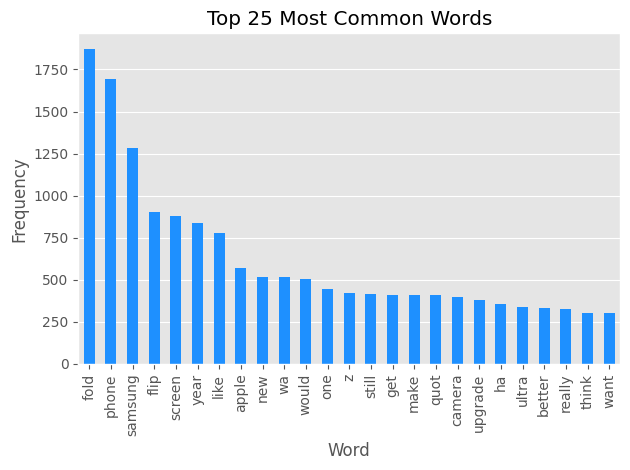

In [26]:
all_comments = ' '.join(df['cleaned_comment'])

words = nltk.word_tokenize(all_comments)

stop_words = set(stopwords.words('english'))
words = [w for w in words if w.lower() not in stop_words]

word_freq = Counter(words)

most_common_words = word_freq.most_common(25)

df_word_freq = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(10, 6))
ax = df_word_freq.plot(kind='bar', x='Word', y='Frequency', legend=False, color='dodgerblue')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 25 Most Common Words')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

In [27]:
df_word_freq

,Word,Frequency
0,fold,1871
1,phone,1692
2,samsung,1284
3,flip,900
4,screen,877
5,year,836
6,like,777
7,apple,572
8,new,517
9,wa,516


## 3.2 Word Cloud

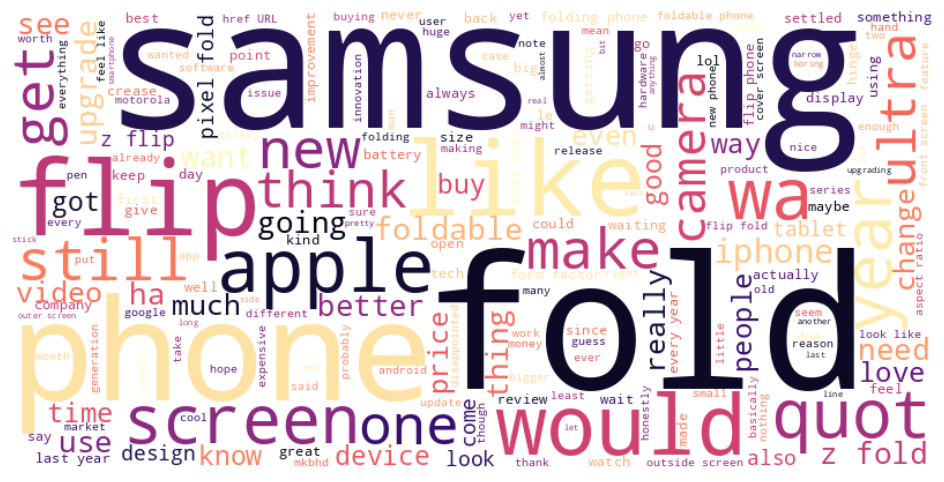

In [ ]:
# Generate the Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma', stopwords=set(stopwords.words('english'))).generate(all_comments)

# Plot the Word Cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 3.3 N-gram Analysis

In [28]:
def ngram_analysis(data, N, top_n):
    all_comments = ' '.join(data['cleaned_comment'])
    words = word_tokenize(all_comments)
    n_grams = list(nltk.ngrams(words, N))
    n_gram_counts = nltk.FreqDist(n_grams)
    result = []
    for n_gram, freq in n_gram_counts.most_common(top_n):
        result.append((f"{' '.join(n_gram)}", freq))

    return result

In [29]:
N = 2
top_n = 25
top_ngrams = ngram_analysis(df, N, top_n)
for i, (n_gram, freq) in enumerate(top_ngrams, 1):
    print(f"{i}. {n_gram}: {freq}")

1. z fold: 243
2. s ultra: 197
3. pixel fold: 152
4. z flip: 138
5. folding phone: 129
6. form factor: 127
7. last year: 113
8. flip phone: 103
9. next year: 96
10. every year: 90
11. foldable phone: 88
12. href URL: 85
13. front screen: 84
14. outside screen: 83
15. flip fold: 79
16. aspect ratio: 70
17. look like: 69
18. feel like: 67
19. new phone: 63
20. cover screen: 60
21. outer screen: 57
22. samsung ha: 51
23. battery life: 48
24. fold fold: 46
25. fold phone: 44


In [30]:
N = 3
top_n = 25
top_ngrams = ngram_analysis(df, N, top_n)
for i, (n_gram, freq) in enumerate(top_ngrams, 1):
    print(f"{i}. {n_gram}: {freq}")

1. honor magic v: 35
2. phone every year: 25
3. HTML HTML HTML: 19
4. google pixel fold: 18
5. tab s ultra: 16
6. new phone every: 12
7. wa really hoping: 12
8. huawei mate x: 12
9. last year model: 12
10. samsung z fold: 11
11. z fold z: 11
12. fold form factor: 11
13. maybe next year: 11
14. would love see: 10
15. wider front screen: 10
16. till next year: 9
17. last year phone: 9
18. fold last year: 9
19. oppo find n: 9
20. phone last year: 9
21. aspect ratio fold: 9
22. screen z fold: 8
23. get z fold: 8
24. fold z flip: 8
25. fold completely flat: 8


In [31]:
N = 4
top_n = 25
top_ngrams = ngram_analysis(df, N, top_n)
for i, (n_gram, freq) in enumerate(top_ngrams, 1):
    print(f"{i}. {n_gram}: {freq}")

1. HTML HTML HTML HTML: 18
2. new phone every year: 8
3. z fold z flip: 6
4. pixel fold form factor: 6
5. href URL flip fold: 6
6. wait till next year: 5
7. quot flip fold others: 5
8. flip fold others quot: 5
9. quot samsung way quot: 4
10. z flip z fold: 4
11. always vibe watch mkbhd: 4
12. vibe watch mkbhd talk: 4
13. watch mkbhd talk tech: 4
14. mkbhd talk tech buying: 4
15. talk tech buying anything: 4
16. key takeaway quick navigation: 4
17. samsung settling guess peaked: 4
18. settling guess peaked design: 4
19. guess peaked design wise: 4
20. peaked design wise already: 4
21. design wise already time: 4
22. wise already time software: 4
23. already time software catch: 4
24. time software catch soon: 4
25. software catch soon possible: 4


# **4 Topic Model Analysis**

In [32]:
df['tokenized_cleaned_comment'] = df['cleaned_comment'].apply(word_tokenize)

dictionary = corpora.Dictionary(df['tokenized_cleaned_comment'])

corpus = [dictionary.doc2bow(tokens) for tokens in df['tokenized_cleaned_comment']]

num_topics = 5
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)

for idx, topic in lda_model.print_topics():
    print(f"Topic {idx + 1}: {topic}")

def get_dominant_topic(tokens):
    bow = dictionary.doc2bow(tokens)
    topics = lda_model.get_document_topics(bow)
    dominant_topic = max(topics, key=lambda x: x[1])
    return dominant_topic[0]

df['dominant_topic'] = df['tokenized_cleaned_comment'].apply(get_dominant_topic)

Topic 1: 0.049*"fold" + 0.032*"samsung" + 0.019*"year" + 0.017*"phone" + 0.014*"s" + 0.014*"like" + 0.013*"upgrade" + 0.012*"ultra" + 0.011*"wa" + 0.009*"new"
Topic 2: 0.059*"flip" + 0.025*"fold" + 0.020*"phone" + 0.020*"z" + 0.016*"screen" + 0.012*"wa" + 0.010*"razr" + 0.008*"href" + 0.008*"URL" + 0.008*"camera"
Topic 3: 0.050*"quot" + 0.029*"samsung" + 0.027*"apple" + 0.025*"video" + 0.016*"mkbhd" + 0.014*"first" + 0.011*"new" + 0.010*"marque" + 0.009*"settled" + 0.008*"android"
Topic 4: 0.039*"screen" + 0.029*"fold" + 0.028*"phone" + 0.013*"like" + 0.011*"get" + 0.010*"one" + 0.009*"camera" + 0.009*"really" + 0.009*"use" + 0.008*"would"
Topic 5: 0.043*"phone" + 0.024*"year" + 0.017*"samsung" + 0.016*"apple" + 0.012*"every" + 0.011*"folding" + 0.011*"would" + 0.009*"one" + 0.009*"design" + 0.009*"foldable"


In [33]:
df

,Thread ID,Comment,comment_length,tokenized_comment,lemmatized_comment,preprocessed_comment,cleaned_comment,tokenized_cleaned_comment,dominant_topic
0,UgxkceJ0F6__Z3bjQNZ4AaABAg,"can someone tell me, why mkbhd stopped reviewi...",65,"[can, someone, tell, me, ,, why, mkbhd, stoppe...","[can, someone, tell, me, ,, why, mkbhd, stoppe...","[someone, tell, ,, mkbhd, stopped, reviewing, ...",someone tell mkbhd stopped reviewing xiaomi pr...,"[someone, tell, mkbhd, stopped, reviewing, xia...",2
1,UgxDjx9DXh_aYMqfKeJ4AaABAg,i bought fold 3 yesterday because of its way c...,107,"[i, bought, fold, 3, yesterday, because, of, i...","[i, bought, fold, 3, yesterday, because, of, i...","[bought, fold, 3, yesterday, way, cheaper, ., ...",bought fold yesterday way cheaper good phone p...,"[bought, fold, yesterday, way, cheaper, good, ...",0
2,Ugw7CyPzykp7gd-6I0B4AaABAg,삼성 폰 많이 사주세요,12,"[삼성, 폰, 많이, 사주세요]","[삼성, 폰, 많이, 사주세요]","[삼성, 폰, 많이, 사주세요]",,[],0
3,UgwsOiu_uADVKO7jjUZ4AaABAg,it sucks android can&#39;t handle certain dj a...,184,"[it, sucks, android, can, &, #, 39, ;, t, hand...","[it, suck, android, can, &, #, 39, ;, t, handl...","[suck, android, &, #, 39, ;, handle, certain, ...",suck android handle certain dj app like djay p...,"[suck, android, handle, certain, dj, app, like...",4
4,UgwoIURLQ4SNKo82Gzt4AaABAg,how much is the z fold 5?,25,"[how, much, is, the, z, fold, 5, ?]","[how, much, is, the, z, fold, 5, ?]","[much, z, fold, 5, ?]",much z fold,"[much, z, fold]",1
...,...,...,...,...,...,...,...,...,...
4616,UgymEuVlsbSLojgABeF4AaABAg,first one here,14,"[first, one, here]","[first, one, here]","[first, one]",first one,"[first, one]",2
4617,UgyebOKVDyQCNoSp09B4AaABAg,first,5,[first],[first],[first],first,[first],2
4618,UgxtPT248Q5-pHTjAAF4AaABAg,HTMLHTML,36,[HTMLHTML],[HTMLHTML],[HTMLHTML],HTMLHTML,[HTMLHTML],2
4619,UgzB_DG0nAR9FDje40N4AaABAg,first,5,[first],[first],[first],first,[first],2


In [37]:
# Count the number of comments per topic
topic_counts = df['dominant_topic'].value_counts().reset_index()
topic_counts.columns = ['Topic ID', 'Comment Count']

# Calculate the percentage of comments per topic
total_comments = len(df)
topic_counts['Percentage'] = (topic_counts['Comment Count'] / total_comments) * 100

# Optionally, you can merge the topic keywords with the table
topic_keywords = []
for topic_id in topic_counts['Topic ID']:
    topic_keywords.append(lda_model.print_topic(topic_id))

topic_counts['Keywords'] = topic_keywords

In [38]:
topic_counts

,Topic ID,Comment Count,Percentage,Keywords
0,0,1770,38.311688,"0.049*""fold"" + 0.032*""samsung"" + 0.019*""year"" ..."
1,3,954,20.649351,"0.039*""screen"" + 0.029*""fold"" + 0.028*""phone"" ..."
2,1,728,15.757576,"0.059*""flip"" + 0.025*""fold"" + 0.020*""phone"" + ..."
3,4,678,14.675325,"0.043*""phone"" + 0.024*""year"" + 0.017*""samsung""..."
4,2,490,10.606061,"0.050*""quot"" + 0.029*""samsung"" + 0.027*""apple""..."


In [41]:
# Calculate perplexity
perplexity = lda_model.log_perplexity(corpus)

# Calculate coherence score
coherence_model = CoherenceModel(model=lda_model, texts=df['tokenized_cleaned_comment'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

print(f"Perplexity: {perplexity}")
print(f"Coherence Score: {coherence_score}")

Perplexity: -7.272957259448902
Coherence Score: 0.5231211811781796


# **5 Sentiment Analysis**

## 5.1 Sentiment scoring models (Lexicon-based approach) - VADER analysis

In [42]:
analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    sentiment_score = analyzer.polarity_scores(text)
    return sentiment_score['compound']

df['vader_sentiment_comment'] = df['Comment'].apply(vader_sentiment)
df['vader_sentiment_cleaned_comment'] = df['cleaned_comment'].apply(vader_sentiment)

In [43]:
df

,Thread ID,Comment,comment_length,tokenized_comment,lemmatized_comment,preprocessed_comment,cleaned_comment,tokenized_cleaned_comment,dominant_topic,vader_sentiment_comment,vader_sentiment_cleaned_comment
0,UgxkceJ0F6__Z3bjQNZ4AaABAg,"can someone tell me, why mkbhd stopped reviewi...",65,"[can, someone, tell, me, ,, why, mkbhd, stoppe...","[can, someone, tell, me, ,, why, mkbhd, stoppe...","[someone, tell, ,, mkbhd, stopped, reviewing, ...",someone tell mkbhd stopped reviewing xiaomi pr...,"[someone, tell, mkbhd, stopped, reviewing, xia...",2,-0.2263,-0.2263
1,UgxDjx9DXh_aYMqfKeJ4AaABAg,i bought fold 3 yesterday because of its way c...,107,"[i, bought, fold, 3, yesterday, because, of, i...","[i, bought, fold, 3, yesterday, because, of, i...","[bought, fold, 3, yesterday, way, cheaper, ., ...",bought fold yesterday way cheaper good phone p...,"[bought, fold, yesterday, way, cheaper, good, ...",0,-0.5859,-0.1531
2,Ugw7CyPzykp7gd-6I0B4AaABAg,삼성 폰 많이 사주세요,12,"[삼성, 폰, 많이, 사주세요]","[삼성, 폰, 많이, 사주세요]","[삼성, 폰, 많이, 사주세요]",,[],0,0.0000,0.0000
3,UgwsOiu_uADVKO7jjUZ4AaABAg,it sucks android can&#39;t handle certain dj a...,184,"[it, sucks, android, can, &, #, 39, ;, t, hand...","[it, suck, android, can, &, #, 39, ;, t, handl...","[suck, android, &, #, 39, ;, handle, certain, ...",suck android handle certain dj app like djay p...,"[suck, android, handle, certain, dj, app, like...",4,0.1406,0.4767
4,UgwoIURLQ4SNKo82Gzt4AaABAg,how much is the z fold 5?,25,"[how, much, is, the, z, fold, 5, ?]","[how, much, is, the, z, fold, 5, ?]","[much, z, fold, 5, ?]",much z fold,"[much, z, fold]",1,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
4616,UgymEuVlsbSLojgABeF4AaABAg,first one here,14,"[first, one, here]","[first, one, here]","[first, one]",first one,"[first, one]",2,0.0000,0.0000
4617,UgyebOKVDyQCNoSp09B4AaABAg,first,5,[first],[first],[first],first,[first],2,0.0000,0.0000
4618,UgxtPT248Q5-pHTjAAF4AaABAg,HTMLHTML,36,[HTMLHTML],[HTMLHTML],[HTMLHTML],HTMLHTML,[HTMLHTML],2,0.0000,0.0000
4619,UgzB_DG0nAR9FDje40N4AaABAg,first,5,[first],[first],[first],first,[first],2,0.0000,0.0000


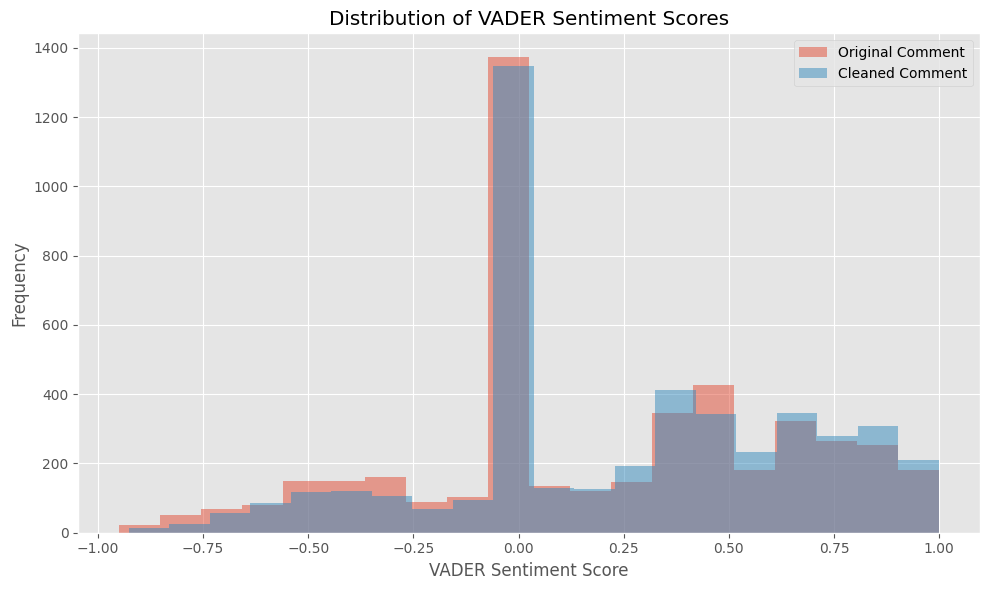

In [44]:
plt.figure(figsize=(10, 6))
plt.hist(df['vader_sentiment_comment'], bins=20, alpha=0.5, label='Original Comment')
plt.hist(df['vader_sentiment_cleaned_comment'], bins=20, alpha=0.5, label='Cleaned Comment')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of VADER Sentiment Scores')
plt.legend()
plt.tight_layout()
plt.show()

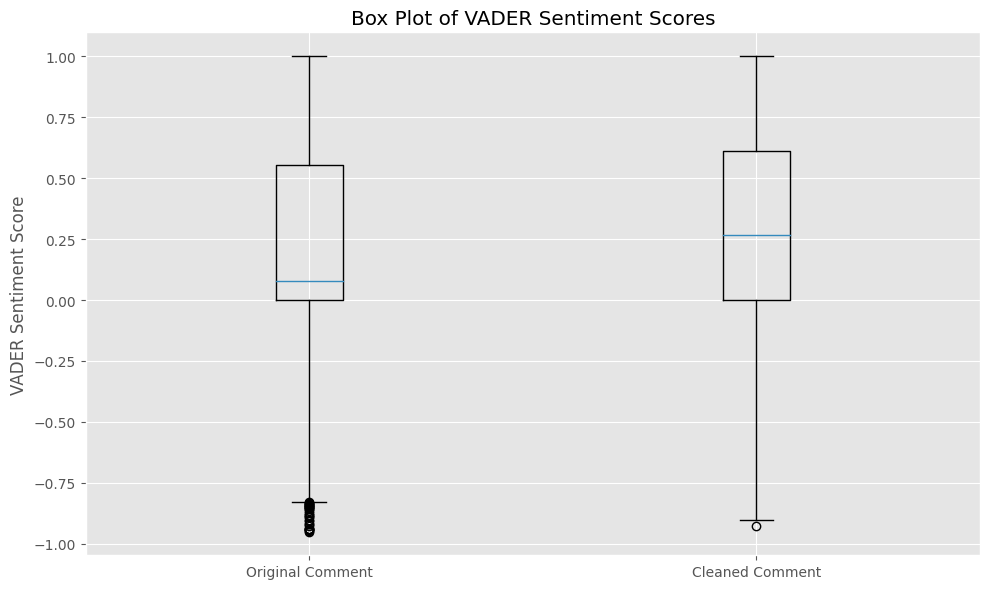

In [46]:
plt.figure(figsize=(10, 6))
plt.boxplot([df['vader_sentiment_comment'], df['vader_sentiment_cleaned_comment']], labels=['Original Comment', 'Cleaned Comment'])
plt.ylabel('VADER Sentiment Score')
plt.title('Box Plot of VADER Sentiment Scores')
plt.tight_layout()
plt.show()

In [47]:
summary_df_vader = pd.DataFrame()

comment_summary = df['vader_sentiment_comment'].describe()
summary_df_vader['Original Comment - VADER Sentiment'] = comment_summary

cleaned_comment_summary = df['vader_sentiment_cleaned_comment'].describe()
summary_df_vader['Cleaned Comment - VADER Sentiment'] = cleaned_comment_summary

summary_df_vader

,Original Comment - VADER Sentiment,Cleaned Comment - VADER Sentiment
count,4620.000000,4620.000000
mean,0.198483,0.251156
std,0.432556,0.418765
min,-0.948900,-0.926900
25%,0.000000,0.000000
50%,0.077200,0.266300
75%,0.551700,0.612400
max,0.999700,0.999600


## 5.2 Rule based approaches (based on Parts of Speech)

In [48]:
analyzer = SentimentIntensityAnalyzer()

def rule_based_sentiment(text):
    pos_tags = pos_tag(word_tokenize(text))

    sentiment_score = 0

    for word, pos in pos_tags:
        if pos.startswith('JJ') or pos.startswith('RB'):
            sentiment_score += analyzer.polarity_scores(word)['compound']
        elif pos.startswith('NN') or pos.startswith('VB'):
            sentiment_score += analyzer.polarity_scores(word)['compound'] * 0.8

    return sentiment_score

df['rule_based_sentiment_comment'] = df['Comment'].apply(rule_based_sentiment)
df['rule_based_sentiment_cleaned_comment'] = df['cleaned_comment'].apply(rule_based_sentiment)

In [49]:
df

,Thread ID,Comment,comment_length,tokenized_comment,lemmatized_comment,preprocessed_comment,cleaned_comment,tokenized_cleaned_comment,dominant_topic,vader_sentiment_comment,vader_sentiment_cleaned_comment,rule_based_sentiment_comment,rule_based_sentiment_cleaned_comment
0,UgxkceJ0F6__Z3bjQNZ4AaABAg,"can someone tell me, why mkbhd stopped reviewi...",65,"[can, someone, tell, me, ,, why, mkbhd, stoppe...","[can, someone, tell, me, ,, why, mkbhd, stoppe...","[someone, tell, ,, mkbhd, stopped, reviewing, ...",someone tell mkbhd stopped reviewing xiaomi pr...,"[someone, tell, mkbhd, stopped, reviewing, xia...",2,-0.2263,-0.2263,-0.18104,-0.18104
1,UgxDjx9DXh_aYMqfKeJ4AaABAg,i bought fold 3 yesterday because of its way c...,107,"[i, bought, fold, 3, yesterday, because, of, i...","[i, bought, fold, 3, yesterday, because, of, i...","[bought, fold, 3, yesterday, way, cheaper, ., ...",bought fold yesterday way cheaper good phone p...,"[bought, fold, yesterday, way, cheaper, good, ...",0,-0.5859,-0.1531,-0.10190,-0.10190
2,Ugw7CyPzykp7gd-6I0B4AaABAg,삼성 폰 많이 사주세요,12,"[삼성, 폰, 많이, 사주세요]","[삼성, 폰, 많이, 사주세요]","[삼성, 폰, 많이, 사주세요]",,[],0,0.0000,0.0000,0.00000,0.00000
3,UgwsOiu_uADVKO7jjUZ4AaABAg,it sucks android can&#39;t handle certain dj a...,184,"[it, sucks, android, can, &, #, 39, ;, t, hand...","[it, suck, android, can, &, #, 39, ;, t, handl...","[suck, android, &, #, 39, ;, handle, certain, ...",suck android handle certain dj app like djay p...,"[suck, android, handle, certain, dj, app, like...",4,0.1406,0.4767,-0.01576,0.10480
4,UgwoIURLQ4SNKo82Gzt4AaABAg,how much is the z fold 5?,25,"[how, much, is, the, z, fold, 5, ?]","[how, much, is, the, z, fold, 5, ?]","[much, z, fold, 5, ?]",much z fold,"[much, z, fold]",1,0.0000,0.0000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4616,UgymEuVlsbSLojgABeF4AaABAg,first one here,14,"[first, one, here]","[first, one, here]","[first, one]",first one,"[first, one]",2,0.0000,0.0000,0.00000,0.00000
4617,UgyebOKVDyQCNoSp09B4AaABAg,first,5,[first],[first],[first],first,[first],2,0.0000,0.0000,0.00000,0.00000
4618,UgxtPT248Q5-pHTjAAF4AaABAg,HTMLHTML,36,[HTMLHTML],[HTMLHTML],[HTMLHTML],HTMLHTML,[HTMLHTML],2,0.0000,0.0000,0.00000,0.00000
4619,UgzB_DG0nAR9FDje40N4AaABAg,first,5,[first],[first],[first],first,[first],2,0.0000,0.0000,0.00000,0.00000


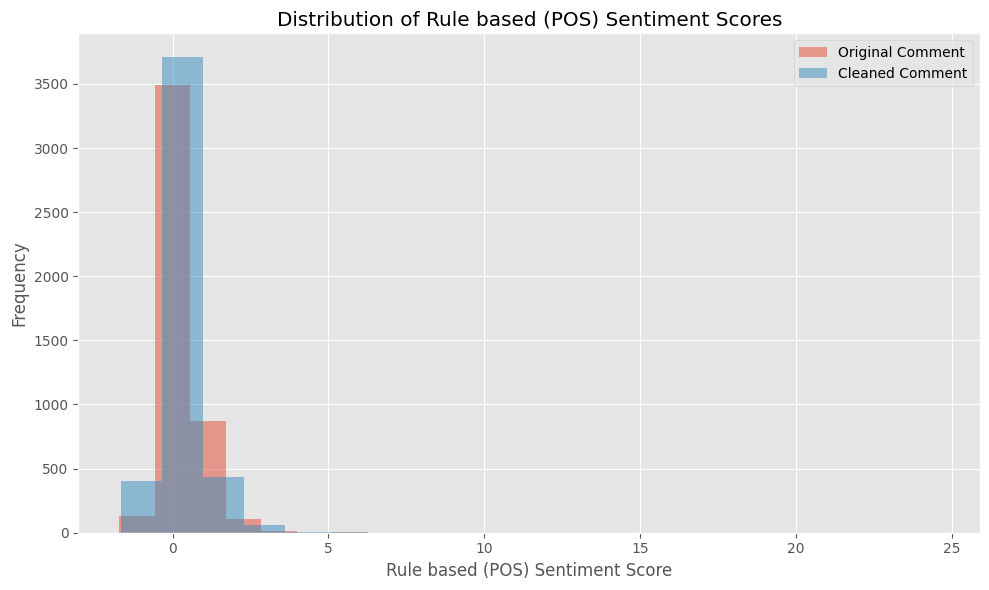

In [50]:
plt.figure(figsize=(10, 6))
plt.hist(df['rule_based_sentiment_comment'], bins=20, alpha=0.5, label='Original Comment')
plt.hist(df['rule_based_sentiment_cleaned_comment'], bins=20, alpha=0.5, label='Cleaned Comment')
plt.xlabel('Rule based (POS) Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Rule based (POS) Sentiment Scores')
plt.legend()
plt.tight_layout()
plt.show()

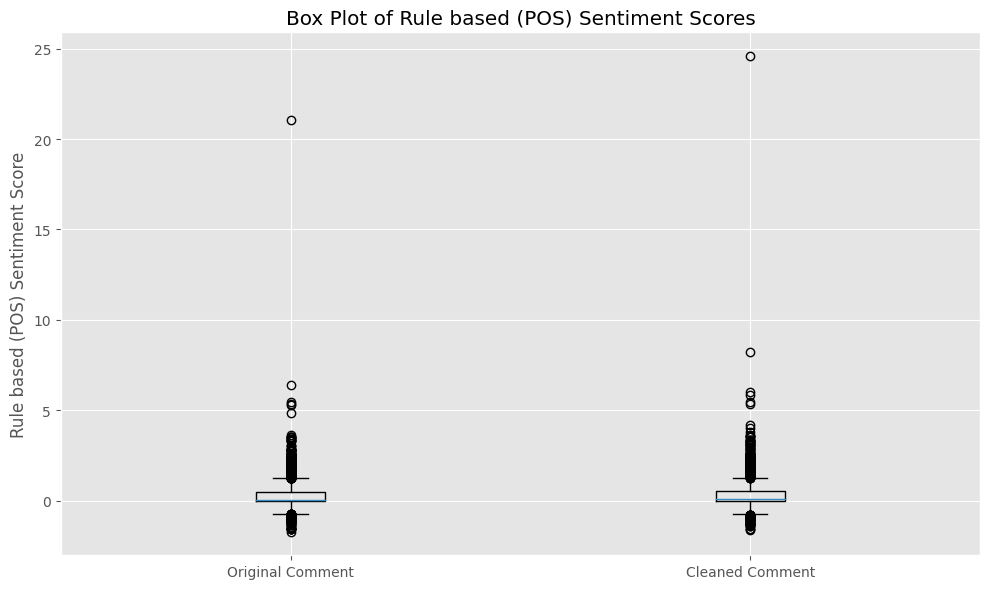

In [51]:
plt.figure(figsize=(10, 6))
plt.boxplot([df['rule_based_sentiment_comment'], df['rule_based_sentiment_cleaned_comment']], labels=['Original Comment', 'Cleaned Comment'])
plt.ylabel('Rule based (POS) Sentiment Score')
plt.title('Box Plot of Rule based (POS) Sentiment Scores')
plt.tight_layout()
plt.show()

In [52]:
summary_df_pos = pd.DataFrame()

comment_summary = df['rule_based_sentiment_comment'].describe()
summary_df_pos['Original Comment - Rule based (POS) Sentiment'] = comment_summary

cleaned_comment_summary = df['rule_based_sentiment_cleaned_comment'].describe()
summary_df_pos['Cleaned Comment - Rule based (POS) Sentiment'] = cleaned_comment_summary

summary_df_pos

,Original Comment - Rule based (POS) Sentiment,Cleaned Comment - Rule based (POS) Sentiment
count,4620.000000,4620.000000
mean,0.282213,0.308255
std,0.679778,0.731022
min,-1.705160,-1.646620
25%,0.000000,0.000000
50%,0.061760,0.082160
75%,0.493900,0.509520
max,21.071840,24.585440
